In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import logging
from google.colab import drive

# Mount Google Drive
def load_data_from_drive(file_path: str, encoding: str = 'ISO-8859-1') -> pd.DataFrame:
    logging.info(f'Loading data from {file_path}')
    drive.mount('/content/drive', force_remount=True)
    df = pd.read_csv(file_path, encoding=encoding)
    logging.info('Data loaded successfully')
    return df

# Extract returns from price data
def extract_returns_from_dataframe(df: pd.DataFrame):
    df = df.drop(index=[0, 1])
    df = df.rename(columns={'Ticker': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])

    close_cols = [col for col in df.columns if col.endswith('.3')]
    tickers = [col.replace('.3', '') for col in close_cols]

    close_prices = df[close_cols].astype(float)
    close_prices.columns = tickers
    close_prices.index = df['Date']

    returns = close_prices.pct_change(fill_method=None).dropna()
    return returns, close_prices

# Portfolio performance and drawdown
def compute_portfolio_performance(weights, returns):
    port_ret = np.dot(weights, returns.mean()) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe = (port_ret - 0.02) / port_vol
    return port_ret, port_vol, sharpe

def compute_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# Michaud resampling with minimum return constraint
def michaud_resampling_min_return(expected_returns, cov_matrix, min_return=0.06, n_simulations=500):
    n_assets = len(expected_returns)
    weights_list = []

    for _ in range(n_simulations):
        simulated_returns = expected_returns + np.random.normal(0, 0.02, size=n_assets)

        def objective(weights):
            return np.sqrt(weights.T @ cov_matrix @ weights)

        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: np.dot(x, simulated_returns) - min_return}
        )

        bounds = tuple((0, 1) for _ in range(n_assets))
        init_guess = np.repeat(1 / n_assets, n_assets)

        result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            weights_list.append(result.x)

    return np.mean(weights_list, axis=0) if weights_list else np.repeat(1 / n_assets, n_assets)

# Final analysis function with correct 4-class grouping
def analyze_portfolio_extended(df: pd.DataFrame, benchmark_weights: dict, selected_tickers=None, min_return=0.06, rf=0.02):
    # Asset class mapping (4 groups)
    ticker_to_class = {
        'SPY': 'US Equity', 'XLU': 'US Equity', 'XLP': 'US Equity',
        'XIC.TO': 'International', 'IEFA': 'International', 'EWJ': 'International', 'VWO': 'International',
        'IEF': 'Bonds', 'SHV': 'Bonds', 'XCB': 'Bonds',
        'IFRA': 'Alternatives', 'GOLD': 'Alternatives', 'VNQ': 'Alternatives', 'HEDGE': 'Alternatives', 'BTC': 'Alternatives'
    }

    returns, prices = extract_returns_from_dataframe(df)

    if selected_tickers:
        returns = returns[selected_tickers]
        prices = prices[selected_tickers]

    tickers = returns.columns.tolist()
    exp_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    weights = michaud_resampling_min_return(exp_returns.values, cov_matrix.values, min_return=min_return)
    weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': weights})

    port_ret, port_vol, sharpe = compute_portfolio_performance(weights, returns)
    sortino = (returns @ weights).mean() * 252 / (returns[returns < 0].std().mean() * np.sqrt(252))
    cum_returns = (returns @ weights).add(1).cumprod()
    drawdown = compute_drawdown(cum_returns)

    bench_weights = np.array([benchmark_weights.get(ticker, 0) for ticker in tickers])
    bench_ret = np.dot(bench_weights, exp_returns)
    excess_ret = port_ret - bench_ret

    pnl = returns @ weights
    var_95 = np.percentile(pnl, 5)

    tracking_error = np.std((returns @ weights) - (returns @ bench_weights)) * np.sqrt(252)
    info_ratio = excess_ret / tracking_error if tracking_error != 0 else np.nan
    allocation_effect = sum((weights - bench_weights) * exp_returns)
    selection_effect = sum(bench_weights * (exp_returns - np.dot(bench_weights, exp_returns)))

    vol_par_classe = returns.std() * np.sqrt(252)
    correlation = returns.corr()

    # Group returns by 4 asset classes
    returns_by_class = {}
    for ticker in returns.columns:
        asset_class = ticker_to_class.get(ticker, 'Alternatives')
        if asset_class:
            returns_by_class.setdefault(asset_class, []).append(returns[ticker])

    class_returns_df = pd.DataFrame({
        asset_class: pd.concat(series_list, axis=1).mean(axis=1)
        for asset_class, series_list in returns_by_class.items()
    })
    correlation_by_class = class_returns_df.corr()

    # === Output ===
    print("📊 Poids du portefeuille optimisé :\n", weights_df)
    print(f"🎯 Rendement annualisé : {port_ret:.2%}")
    print(f"📈 Excès de rendement vs Benchmark : {excess_ret:.2%}")
    print(f"📉 Volatilité annualisée : {port_vol:.2%}")
    print(f"⚠️  VaR Historique à 95% : {var_95:.2%}")
    print(f"⚖️  Sharpe Ratio : {sharpe:.2f}")
    print(f"🎯 Sortino Ratio : {sortino:.2f}")
    print(f"📊 Information Ratio : {info_ratio:.2f}")
    print(f"🔻 Max Drawdown : {drawdown:.2%}")
    print(f"📌 Allocation Effect : {allocation_effect:.2%}")
    print(f"📌 Selection Effect : {selection_effect:.2%}")

    # === Plots ===
    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns, label='Rendement cumulé')
    plt.title("📈 Rendement cumulé du portefeuille")
    plt.xlabel("Date")
    plt.ylabel("Rendement cumulé")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("🔗 Corrélation entre actifs (individuels)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_by_class, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("🔗 Corrélation entre classes d'actifs")
    plt.tight_layout()
    plt.show()

    return {
        "weights": weights_df,
        "returns": port_ret,
        "excess_return": excess_ret,
        "volatility": port_vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "var_95": var_95,
        "information_ratio": info_ratio,
        "drawdown": drawdown,
        "allocation_effect": allocation_effect,
        "selection_effect": selection_effect,
        "volatility_by_class": vol_par_classe,
        "correlation_matrix": correlation,
        "correlation_by_class": correlation_by_class
    }


Mounted at /content/drive
📊 Poids du portefeuille optimisé :
       Ticker        Weight
0        GLD  2.453303e-03
1     XIU.TO  1.215844e-02
2       BITO  4.323335e-03
3    ZJPN.TO  4.793328e-03
4        LQD  2.195768e-17
5        IEF  2.057605e-17
6     XCB.TO  1.555417e-03
7        EWJ  3.821858e-05
8     XEF.TO  1.281496e-02
9        VEA  6.497010e-04
10      BTAL  1.973730e-02
11  PSU-U.TO  4.839745e-01
12       XLU  8.282826e-05
13       SHV  4.215610e-01
14  CGL-C.TO  3.460139e-02
15       XLP  2.422347e-04
16    ZUT.TO  9.352568e-18
17    ZRE.TO  1.162013e-17
18    ZEM.TO  1.014059e-03
🎯 Rendement annualisé : 5.17%
📈 Excès de rendement vs Benchmark : 4.31%
📉 Volatilité annualisée : 0.77%
⚠️  VaR Historique à 95% : -0.06%
⚖️  Sharpe Ratio : 4.11
🎯 Sortino Ratio : 0.51
📊 Information Ratio : 3.12
🔻 Max Drawdown : -0.87%
📌 Allocation Effect : 4.31%
📌 Selection Effect : 0.58%


<ipython-input-1-3023697778>:147: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


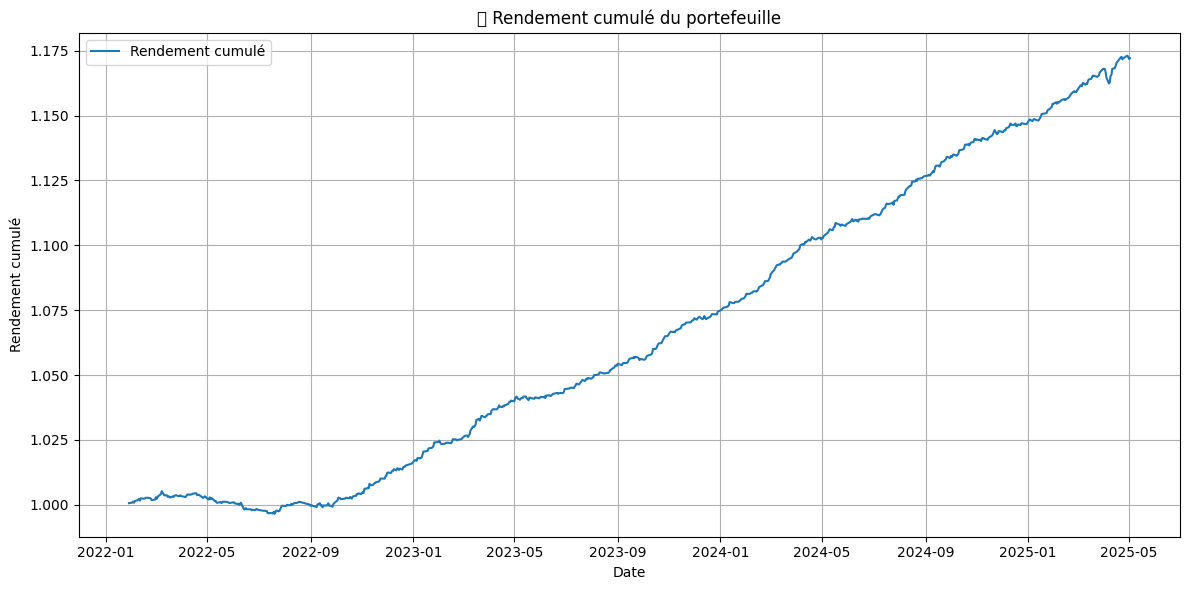

<ipython-input-1-3023697778>:153: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


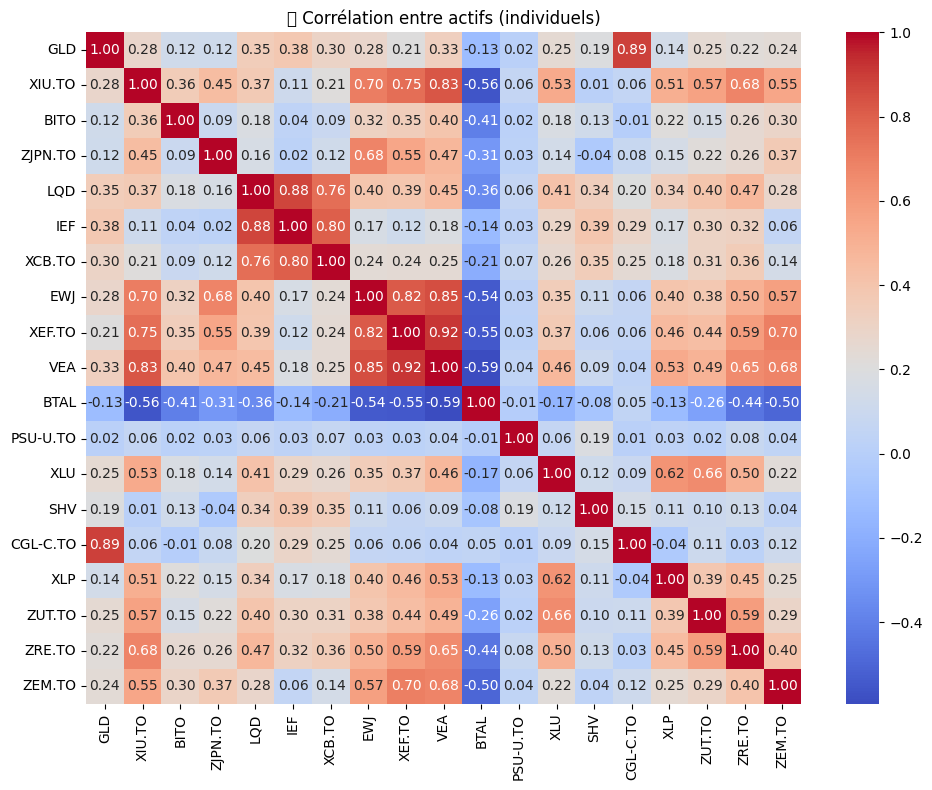

<ipython-input-1-3023697778>:159: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


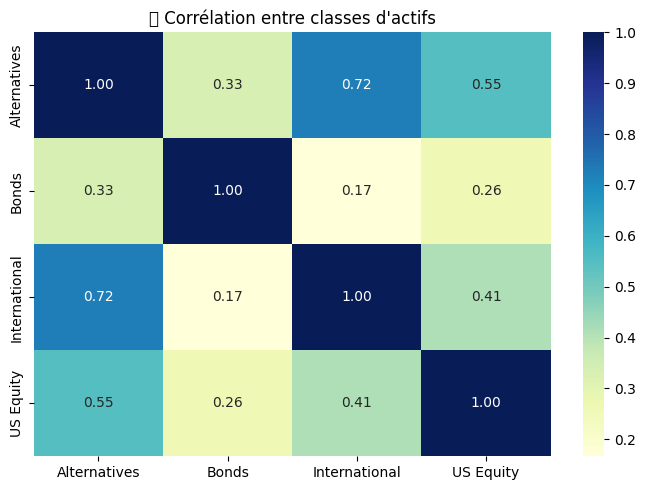

In [ ]:
# Scaling factor for 40% equity target
equity_scale = 0.40

benchmark_weights = {
    # Equities (scaled to 40%)
    'SPY': 0.28 * equity_scale,
    'XLU': 0.06 * equity_scale,
    'XLP': 0.06 * equity_scale,
    'XIC.TO': 0.18 * equity_scale,
    'IEFA': 0.27 * equity_scale,
    'EWJ': 0.03 * equity_scale,
    'VWO': 0.12 * equity_scale,

    # Bonds (30%)
    'SHV': 0.15,
    'IEF': 0.12,
    'XCB': 0.03,

    # Alternatives (30%)
    'IFRA': 0.105,
    'GOLD': 0.09,
    'VNQ': 0.045,
    'HEDGE': 0.03,
    'BTC': 0.03
}

df = load_data_from_drive('/content/drive/MyDrive/ETF_Prices (1).csv')
results = analyze_portfolio_extended(df, benchmark_weights)


In [ ]:
def analyze_portfolio_extended(df: pd.DataFrame, benchmark_weights: dict, selected_tickers=None, min_return=0.06, rf=0.02):
    # Asset class mapping (4 groups)
    ticker_to_class = {
        'SPY': 'US Equity', 'XLU': 'US Equity', 'XLP': 'US Equity',
        'XIC.TO': 'International', 'IEFA': 'International', 'EWJ': 'International', 'VWO': 'International',
        'IEF': 'Bonds', 'SHV': 'Bonds', 'XCB': 'Bonds',
        'IFRA': 'Alternatives', 'GOLD': 'Alternatives', 'VNQ': 'Alternatives', 'HEDGE': 'Alternatives', 'BTC': 'Alternatives'
    }

    returns, prices = extract_returns_from_dataframe(df)
    if selected_tickers:
        returns = returns[selected_tickers]
        prices = prices[selected_tickers]

    tickers = returns.columns.tolist()
    exp_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    weights = michaud_resampling_min_return(exp_returns.values, cov_matrix.values, min_return=min_return)
    weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': weights})

    port_ret, port_vol, sharpe = compute_portfolio_performance(weights, returns)
    sortino = (returns @ weights).mean() * 252 / (returns[returns < 0].std().mean() * np.sqrt(252))
    cum_returns = (returns @ weights).add(1).cumprod()
    drawdown = compute_drawdown(cum_returns)

    bench_weights = np.array([benchmark_weights.get(ticker, 0) for ticker in tickers])
    bench_ret = np.dot(bench_weights, exp_returns)
    excess_ret = port_ret - bench_ret

    pnl = returns @ weights
    var_95 = np.percentile(pnl, 5)

    tracking_error = np.std((returns @ weights) - (returns @ bench_weights)) * np.sqrt(252)
    info_ratio = excess_ret / tracking_error if tracking_error != 0 else np.nan
    allocation_effect = sum((weights - bench_weights) * exp_returns)
    selection_effect = sum(bench_weights * (exp_returns - np.dot(bench_weights, exp_returns)))

    vol_par_classe = returns.std() * np.sqrt(252)
    correlation = returns.corr()

    # Ensure all asset classes are initialized even if empty
    asset_classes = ['US Equity', 'International', 'Bonds', 'Alternatives']
    returns_by_class = {cls: [] for cls in asset_classes}

    for ticker in returns.columns:
      asset_class = ticker_to_class.get(ticker, 'Alternatives')
      returns_by_class[asset_class].append(returns[ticker])

    # Fill empty classes with NaNs to preserve structure
    class_returns_df = pd.DataFrame({
      asset_class: pd.concat(series_list, axis=1).mean(axis=1)
      if series_list else pd.Series(np.nan, index=returns.index)
      for asset_class, series_list in returns_by_class.items()})

    correlation_by_class = class_returns_df.corr()


    # Class-level performance
    class_returns_mean = class_returns_df.mean() * 252
    class_volatility = class_returns_df.std() * np.sqrt(252)
    print("\n📈 Performance par classe d'actifs:")
    for asset_class in class_returns_df.columns:
        print(f"  - {asset_class}: rendement = {class_returns_mean[asset_class]:.2%}, volatilité = {class_volatility[asset_class]:.2%}")

    # Rolling Sharpe Ratio
    rolling_sharpe = (class_returns_df.rolling(60).mean() * 252) / (class_returns_df.rolling(60).std() * np.sqrt(252))
    rolling_sharpe.plot(figsize=(10, 6))
    plt.title("📈 Sharpe Ratio glissant (60 jours) par classe d'actifs")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Benchmark vs Portfolio cumulative return
    cum_benchmark = (returns @ bench_weights).add(1).cumprod()
    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns, label='Portefeuille Optimisé')
    plt.plot(cum_benchmark, label='Benchmark Stratégique', linestyle='--')
    plt.title("📈 Rendement cumulé : Optimisé vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Rendement cumulé")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Risk contribution
    marginal_contrib = np.dot(cov_matrix, weights)
    total_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    risk_contrib = weights * marginal_contrib / total_vol
    risk_contrib_df = pd.DataFrame({'Ticker': returns.columns, 'Risk Contribution': risk_contrib})
    print("\n⚠️ Contribution au risque (chaque actif) :")
    print(risk_contrib_df.sort_values(by='Risk Contribution', ascending=False))

    # Summary output
    print("\n📊 Poids du portefeuille optimisé :\n", weights_df)
    print(f"🎯 Rendement annualisé : {port_ret:.2%}")
    print(f"📈 Excès de rendement vs Benchmark : {excess_ret:.2%}")
    print(f"📉 Volatilité annualisée : {port_vol:.2%}")
    print(f"⚠️  VaR Historique à 95% : {var_95:.2%}")
    print(f"⚖️  Sharpe Ratio : {sharpe:.2f}")
    print(f"🎯 Sortino Ratio : {sortino:.2f}")
    print(f"📊 Information Ratio : {info_ratio:.2f}")
    print(f"🔻 Max Drawdown : {drawdown:.2%}")
    print(f"📌 Allocation Effect : {allocation_effect:.2%}")
    print(f"📌 Selection Effect : {selection_effect:.2%}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("🔗 Corrélation entre actifs (individuels)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_by_class, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("🔗 Corrélation entre classes d'actifs")
    plt.tight_layout()
    plt.show()

    return {
        "weights": weights_df,
        "returns": port_ret,
        "excess_return": excess_ret,
        "volatility": port_vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "var_95": var_95,
        "information_ratio": info_ratio,
        "drawdown": drawdown,
        "allocation_effect": allocation_effect,
        "selection_effect": selection_effect,
        "volatility_by_class": vol_par_classe,
        "correlation_matrix": correlation,
        "correlation_by_class": correlation_by_class,
        "risk_contribution": risk_contrib_df,
        "class_returns": class_returns_mean,
        "class_volatility": class_volatility
    }


In [ ]:
def analyze_portfolio_extended(df: pd.DataFrame, benchmark_weights: dict, selected_tickers=None, min_return=0.06, rf=0.02):
    # Asset class mapping (4 groups)
    ticker_to_class = {
        'SPY': 'US Equity', 'XLU': 'US Equity', 'XLP': 'US Equity',
        'XIC.TO': 'International', 'IEFA': 'International', 'EWJ': 'International', 'VWO': 'International',
        'IEF': 'Bonds', 'SHV': 'Bonds', 'XCB': 'Bonds',
        'IFRA': 'Alternatives', 'GOLD': 'Alternatives', 'VNQ': 'Alternatives', 'HEDGE': 'Alternatives', 'BTC': 'Alternatives'
    }

    returns, prices = extract_returns_from_dataframe(df)
    if selected_tickers:
        returns = returns[selected_tickers]
        prices = prices[selected_tickers]

    tickers = returns.columns.tolist()
    exp_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    weights = michaud_resampling_min_return(exp_returns.values, cov_matrix.values, min_return=min_return)
    weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': weights})

    port_ret, port_vol, sharpe = compute_portfolio_performance(weights, returns)
    sortino = (returns @ weights).mean() * 252 / (returns[returns < 0].std().mean() * np.sqrt(252))
    cum_returns = (returns @ weights).add(1).cumprod()
    drawdown = compute_drawdown(cum_returns)

    bench_weights = np.array([benchmark_weights.get(ticker, 0) for ticker in tickers])
    bench_ret = np.dot(bench_weights, exp_returns)
    excess_ret = port_ret - bench_ret

    pnl = returns @ weights
    var_95 = np.percentile(pnl, 5)

    tracking_error = np.std((returns @ weights) - (returns @ bench_weights)) * np.sqrt(252)
    info_ratio = excess_ret / tracking_error if tracking_error != 0 else np.nan
    allocation_effect = sum((weights - bench_weights) * exp_returns)
    selection_effect = sum(bench_weights * (exp_returns - np.dot(bench_weights, exp_returns)))

    vol_par_classe = returns.std() * np.sqrt(252)
    correlation = returns.corr()

    # Ensure all asset classes are initialized even if empty
    asset_classes = ['US Equity', 'International', 'Bonds', 'Alternatives']
    returns_by_class = {cls: [] for cls in asset_classes}

    for ticker in returns.columns:
        asset_class = ticker_to_class.get(ticker, 'Alternatives')
        returns_by_class[asset_class].append(returns[ticker])

    # Fill empty classes with NaNs to preserve structure
    class_returns_df = pd.DataFrame({
        asset_class: pd.concat(series_list, axis=1).mean(axis=1)
        if series_list else pd.Series(np.nan, index=returns.index)
        for asset_class, series_list in returns_by_class.items()})

    correlation_by_class = class_returns_df.corr()

    # Class-level performance
    class_returns_mean = class_returns_df.mean() * 252
    class_volatility = class_returns_df.std() * np.sqrt(252)
    print("\n📈 Performance par classe d'actifs:")
    for asset_class in class_returns_df.columns:
        print(f"  - {asset_class}: rendement = {class_returns_mean[asset_class]:.2%}, volatilité = {class_volatility[asset_class]:.2%}")

    # Rolling Sharpe Ratio
    rolling_sharpe = (class_returns_df.rolling(60).mean() * 252) / (class_returns_df.rolling(60).std() * np.sqrt(252))
    rolling_sharpe.plot(figsize=(10, 6))
    plt.title("📈 Sharpe Ratio glissant (60 jours) par classe d'actifs")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Benchmark vs Portfolio cumulative return
    cum_benchmark = (returns @ bench_weights).add(1).cumprod()
    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns, label='Portefeuille Optimisé')
    plt.plot(cum_benchmark, label='Benchmark Stratégique', linestyle='--')
    plt.title("📈 Rendement cumulé : Optimisé vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Rendement cumulé")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Risk contribution
    marginal_contrib = np.dot(cov_matrix, weights)
    total_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    risk_contrib = weights * marginal_contrib / total_vol
    risk_contrib_df = pd.DataFrame({'Ticker': returns.columns, 'Risk Contribution': risk_contrib})
    print("\n⚠️ Contribution au risque (chaque actif) :")
    print(risk_contrib_df.sort_values(by='Risk Contribution', ascending=False))

    # Monthly portfolio returns (compounded)
    if not isinstance(pnl.index, pd.DatetimeIndex):
        pnl.index = pd.to_datetime(pnl.index)

    pnl = pnl.dropna()
    monthly_returns = (pnl + 1).resample('M').prod() - 1

    # Print monthly returns
    print("\n📅 Rendements mensuels du portefeuille (composés) :")
    print(monthly_returns.to_string(float_format="{:.2%}".format))

    # Summary output
    print("\n📊 Poids du portefeuille optimisé :\n", weights_df)
    print(f"🎯 Rendement annualisé : {port_ret:.2%}")
    print(f"📈 Excès de rendement vs Benchmark : {excess_ret:.2%}")
    print(f"📉 Volatilité annualisée : {port_vol:.2%}")
    print(f"⚠️  VaR Historique à 95% : {var_95:.2%}")
    print(f"⚖️  Sharpe Ratio : {sharpe:.2f}")
    print(f"🎯 Sortino Ratio : {sortino:.2f}")
    print(f"📊 Information Ratio : {info_ratio:.2f}")
    print(f"🔻 Max Drawdown : {drawdown:.2%}")
    print(f"📌 Allocation Effect : {allocation_effect:.2%}")
    print(f"📌 Selection Effect : {selection_effect:.2%}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("🔗 Corrélation entre actifs (individuels)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.heatmap(correlation_by_class, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("🔗 Corrélation entre classes d'actifs")
    plt.tight_layout()
    plt.show()

    return {
        "weights": weights_df,
        "returns": port_ret,
        "excess_return": excess_ret,
        "volatility": port_vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "var_95": var_95,
        "information_ratio": info_ratio,
        "drawdown": drawdown,
        "allocation_effect": allocation_effect,
        "selection_effect": selection_effect,
        "volatility_by_class": vol_par_classe,
        "correlation_matrix": correlation,
        "correlation_by_class": correlation_by_class,
        "risk_contribution": risk_contrib_df,
        "class_returns": class_returns_mean,
        "class_volatility": class_volatility,
        "monthly_returns": monthly_returns
    }



In [ ]:
def run_stress_tests(returns: pd.DataFrame, weights: np.ndarray, ticker_to_class: dict):
    scenarios = {
        "📉 2008-style crash": {
            "shock_class": "US Equity",
            "shock_value": -0.30
        },
        "😷 2020 COVID-style crisis": {
            "shock_class": "Global",
            "exceptions": ["GOLD"],
            "shock_value": -0.20
        },
        "📈 Rate Hike Shock": {
            "shock_class": "Bonds",
            "shock_value": -0.10
        }
    }

    tickers = returns.columns.tolist()
    latest_zero = pd.Series(0, index=tickers)

    class_map = {}
    for ticker, group in ticker_to_class.items():
        class_map.setdefault(group, []).append(ticker)

    shock_results = {}

    for name, cfg in scenarios.items():
        shocked = latest_zero.copy()

        if cfg["shock_class"] == "Global":
            for t in tickers:
                if t not in cfg.get("exceptions", []):
                    shocked[t] = cfg["shock_value"]
        else:
            for t in class_map.get(cfg["shock_class"], []):
                if t in shocked.index:
                    shocked[t] = cfg["shock_value"]

        shocked = shocked[tickers]  # Ensures alignment
        pnl = np.dot(weights, shocked.fillna(0))
        shock_results[name] = pnl

    return pd.DataFrame.from_dict(shock_results, orient="index", columns=["Portfolio Return Under Stress"])


# 🎲 Monte Carlo Simulation for Portfolio Risk
def run_monte_carlo_simulation(returns: pd.DataFrame, weights: np.ndarray, n_sim=10000, horizon_days=21):
    mu = returns.mean()
    cov = returns.cov()
    sim = np.random.multivariate_normal(mu, cov, size=(n_sim, horizon_days))
    port_path = sim @ weights
    cum_returns = np.exp(np.sum(port_path, axis=1)) - 1

    var_95 = np.percentile(cum_returns, 5)
    es_95 = cum_returns[cum_returns <= var_95].mean()

    plt.hist(cum_returns, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95:.2%}')
    plt.axvline(es_95, color='darkred', linestyle='--', label=f'ES 95%: {es_95:.2%}')
    plt.title("🎲 Monte Carlo Simulation of Portfolio Returns")
    plt.xlabel("Cumulative Return over 21 days")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "Monte Carlo VaR 95%": var_95,
        "Monte Carlo ES 95%": es_95
    }



📈 Performance par classe d'actifs:
  - US Equity: rendement = 6.68%, volatilité = 14.74%
  - International: rendement = 9.02%, volatilité = 18.60%
  - Bonds: rendement = 1.32%, volatilité = 4.43%
  - Alternatives: rendement = 10.58%, volatilité = 8.93%


<ipython-input-4-2138413894>:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


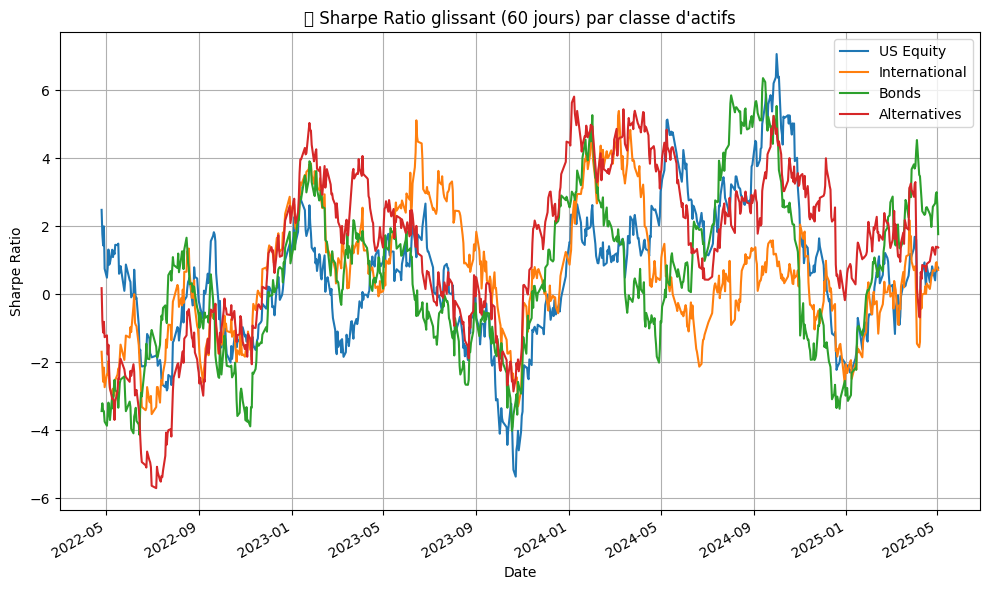

<ipython-input-4-2138413894>:85: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


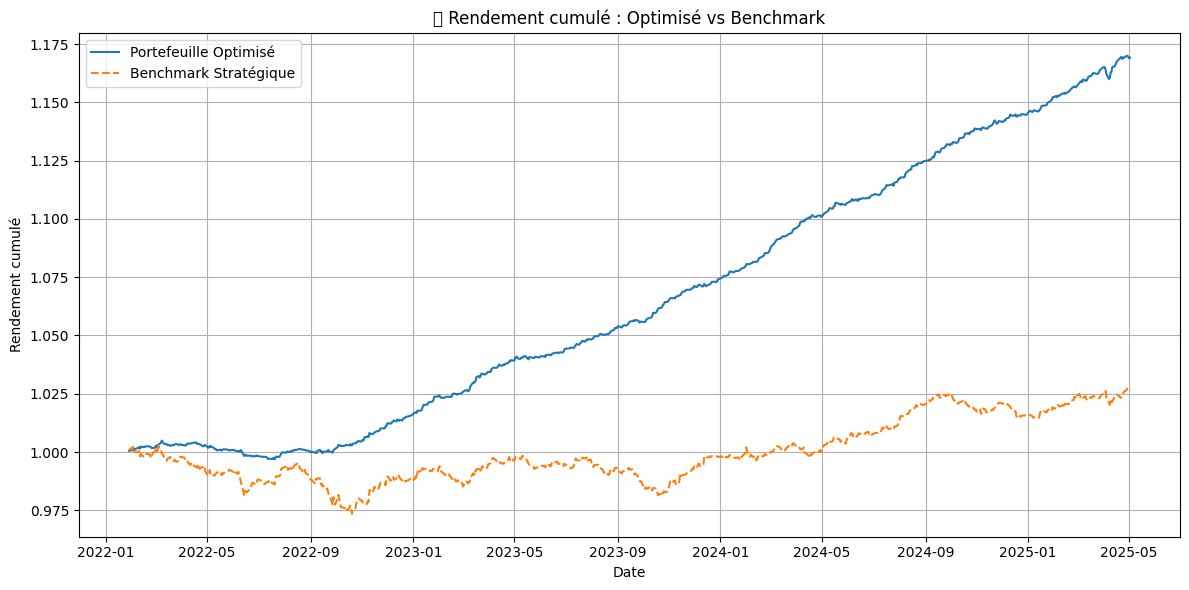


⚠️ Contribution au risque (chaque actif) :
      Ticker  Risk Contribution
14  CGL-C.TO       3.482177e-03
2       BITO       7.822589e-04
1     XIU.TO       6.403669e-04
8     XEF.TO       6.034682e-04
11  PSU-U.TO       4.825585e-04
13       SHV       4.751081e-04
3    ZJPN.TO       1.929797e-04
0        GLD       1.831306e-04
10      BTAL       1.788363e-04
9        VEA       5.940306e-05
6     XCB.TO       4.598066e-05
18    ZEM.TO       4.294115e-05
7        EWJ       3.616773e-06
12       XLU       3.265944e-06
15       XLP       1.799640e-07
4        LQD       1.322012e-08
17    ZRE.TO       6.063761e-19
5        IEF       5.119775e-19
16    ZUT.TO       4.072930e-19

📅 Rendements mensuels du portefeuille (composés) :
Date
2022-01-31    0.08%
2022-02-28    0.11%
2022-03-31    0.13%
2022-04-30   -0.03%
2022-05-31   -0.21%
2022-06-30   -0.24%
2022-07-31    0.16%
2022-08-31    0.05%
2022-09-30    0.10%
2022-10-31    0.31%
2022-11-30    0.67%
2022-12-31    0.46%
2023-01-31    0.81%

<ipython-input-4-2138413894>:101: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = (pnl + 1).resample('M').prod() - 1
<ipython-input-4-2138413894>:123: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


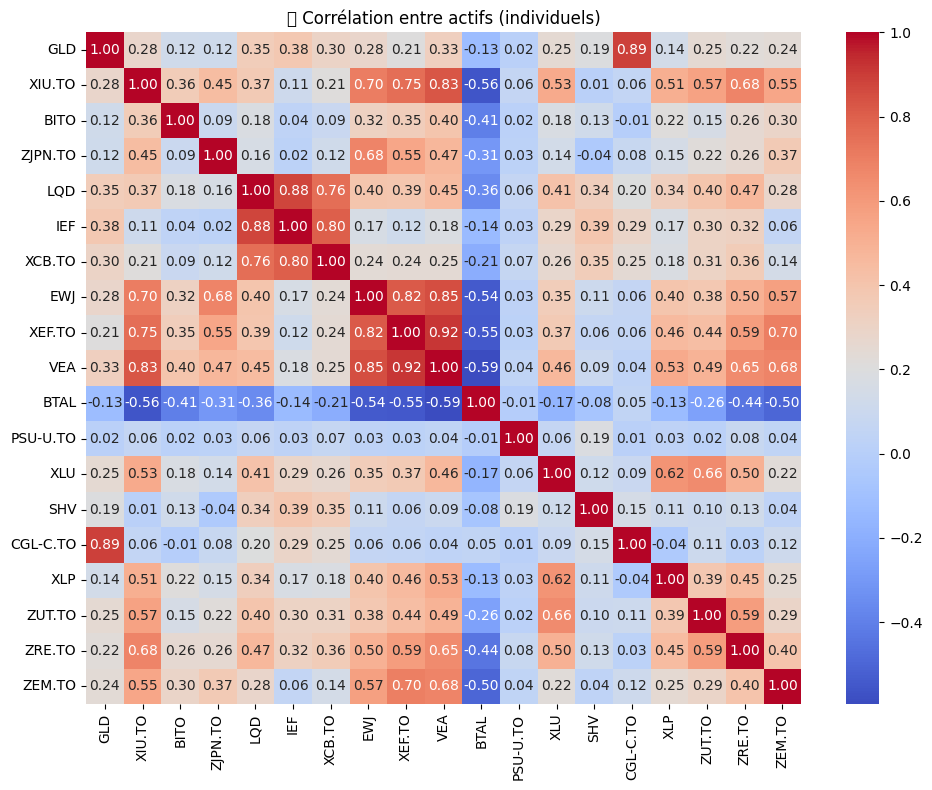

<ipython-input-4-2138413894>:129: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


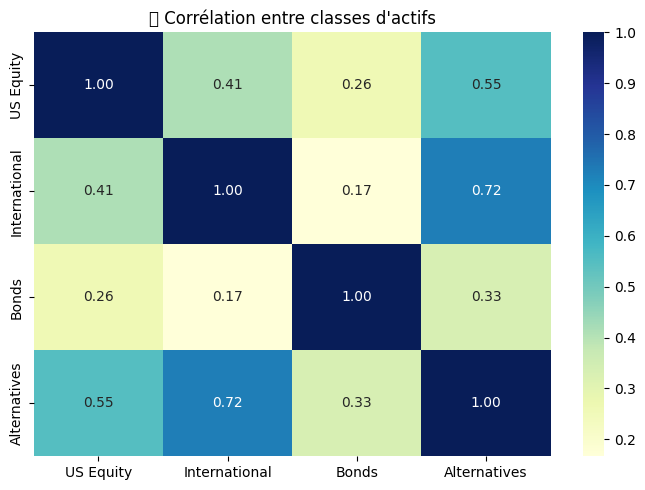

<ipython-input-5-1834980019>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  shocked[t] = cfg["shock_value"]
<ipython-input-5-1834980019>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  shocked[t] = cfg["shock_value"]
<ipython-input-5-1834980019>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  shocked[t] = cfg["shock_value"]


                           Portfolio Return Under Stress
📉 2008-style crash                             -0.000018
😷 2020 COVID-style crisis                      -0.200000
📈 Rate Hike Shock                              -0.041902


<ipython-input-5-1834980019>:65: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


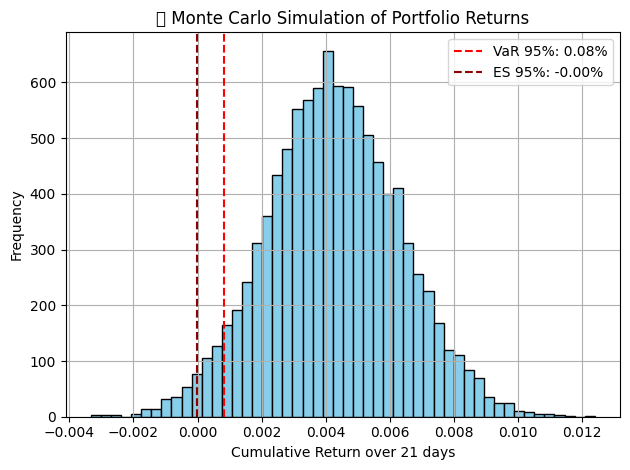

{'Monte Carlo VaR 95%': np.float64(0.0008293331649956382), 'Monte Carlo ES 95%': np.float64(-2.8187014095262473e-05)}


In [ ]:
results = analyze_portfolio_extended(df, benchmark_weights)
returns = extract_returns_from_dataframe(df)[0]
weights = results["weights"]["Weight"].values
ticker_to_class = {
    'SPY': 'US Equity', 'XLU': 'US Equity', 'XLP': 'US Equity',
    'XIC.TO': 'International', 'IEFA': 'International', 'EWJ': 'International', 'VWO': 'International',
    'IEF': 'Bonds', 'SHV': 'Bonds', 'XCB': 'Bonds',
    'IFRA': 'Alternatives', 'GOLD': 'Alternatives', 'VNQ': 'Alternatives', 'HEDGE': 'Alternatives', 'BTC': 'Alternatives'
}

# Stress test results
stress = run_stress_tests(returns, weights, ticker_to_class)
print(stress)

# Monte Carlo
mc = run_monte_carlo_simulation(returns, weights)
print(mc)


In [ ]:
def post_analysis_enhancements(returns, weights, benchmark_weights, ticker_to_class, exp_returns, cum_returns, cum_benchmark, class_returns_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    tickers = returns.columns.tolist()

    # === Sortino Ratio with real downside deviation ===
    rf = 0.02
    pnl = returns @ weights
    downside_returns = pnl[pnl < rf / 252]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino = (pnl.mean() * 252 - rf) / downside_std if downside_std != 0 else np.nan

    # === Attribution by Asset Class ===
    class_alloc_effect = {}
    class_select_effect = {}

    for cls in set(ticker_to_class.values()):
        class_tickers = [t for t in tickers if ticker_to_class.get(t) == cls]
        if not class_tickers:
            continue

        real_w = np.array([weights[tickers.index(t)] for t in class_tickers])
        bench_w = np.array([benchmark_weights.get(t, 0) for t in class_tickers])
        rets = np.array([exp_returns[t] for t in class_tickers])

        alloc_eff = np.sum((real_w - bench_w) * np.mean(rets))
        select_eff = np.sum(bench_w * (rets - np.mean(rets)))

        class_alloc_effect[cls] = alloc_eff
        class_select_effect[cls] = select_eff

    df_attr = pd.DataFrame({
        "Allocation Effect": class_alloc_effect,
        "Selection Effect": class_select_effect
    })

    # === Info Ratio plot
    tracking_error = np.std((returns @ weights) - (returns @ np.array([benchmark_weights.get(t, 0) for t in tickers]))) * np.sqrt(252)
    excess_ret = (returns @ weights).mean() * 252 - np.dot(np.array([benchmark_weights.get(t, 0) for t in tickers]), exp_returns)
    info_ratio = excess_ret / tracking_error if tracking_error != 0 else np.nan

    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns, label=f'Portefeuille Optimisé (IR={info_ratio:.2f})')
    plt.plot(cum_benchmark, label='Benchmark Stratégique', linestyle='--')
    plt.title("📈 Rendement cumulé avec Information Ratio")
    plt.xlabel("Date")
    plt.ylabel("Rendement cumulé")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Monthly Class Heatmap (ignore unmapped tickers)
    # Handle unmapped tickers
    missing = [t for t in returns.columns if t not in ticker_to_class]
    if missing:
        print(f"⚠️ Tickers manquants dans le mapping : {missing}")
    class_cols = [ticker_to_class.get(t, "Unknown") for t in returns.columns]
    safe_class_returns_df = returns.copy()
    safe_class_returns_df.columns = class_cols
    safe_class_returns_df = safe_class_returns_df.groupby(level=0, axis=1).mean()

    monthly_class = (safe_class_returns_df + 1).resample("M").prod() - 1
    plt.figure(figsize=(24, 12))
    sns.heatmap(monthly_class.T, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
    plt.title("📅 Rendement mensuel par classe d'actifs")
    plt.tight_layout()
    plt.show()

    # === Final Print
    print(f"🎯 Sortino Ratio (corrigé) : {sortino:.2f}")
    print("\n📊 Attribution de performance par classe :")
    print(df_attr.round(4))

    return {
        "sortino_corrected": sortino,
        "attribution_by_class": df_attr,
        "info_ratio": info_ratio,
        "monthly_returns_by_class": monthly_class
    }



📈 Performance par classe d'actifs:
  - US Equity: rendement = 6.68%, volatilité = 14.74%
  - International: rendement = 9.02%, volatilité = 18.60%
  - Bonds: rendement = 1.32%, volatilité = 4.43%
  - Alternatives: rendement = 10.58%, volatilité = 8.93%


<ipython-input-4-2138413894>:72: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


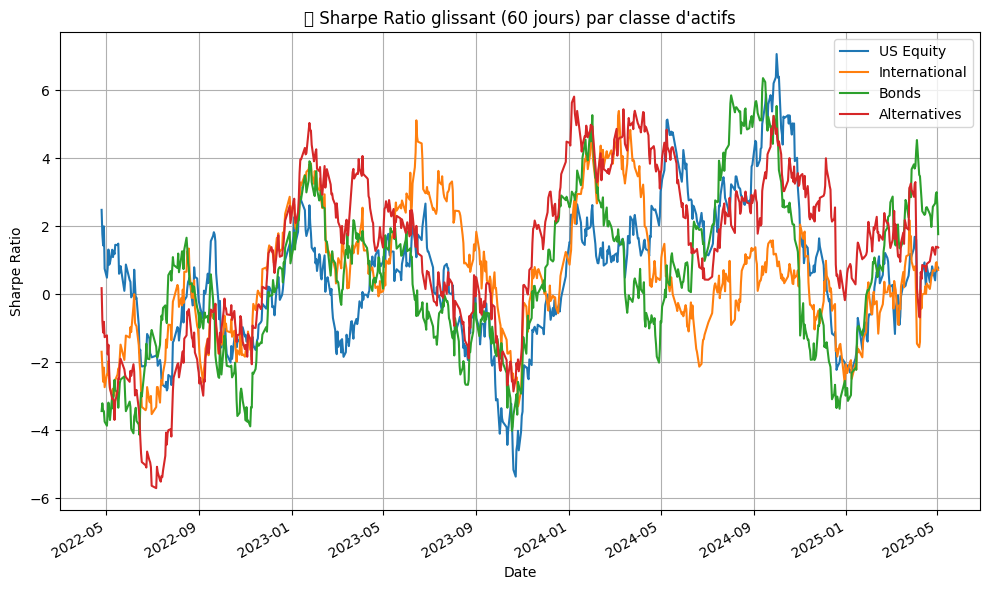

<ipython-input-4-2138413894>:85: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


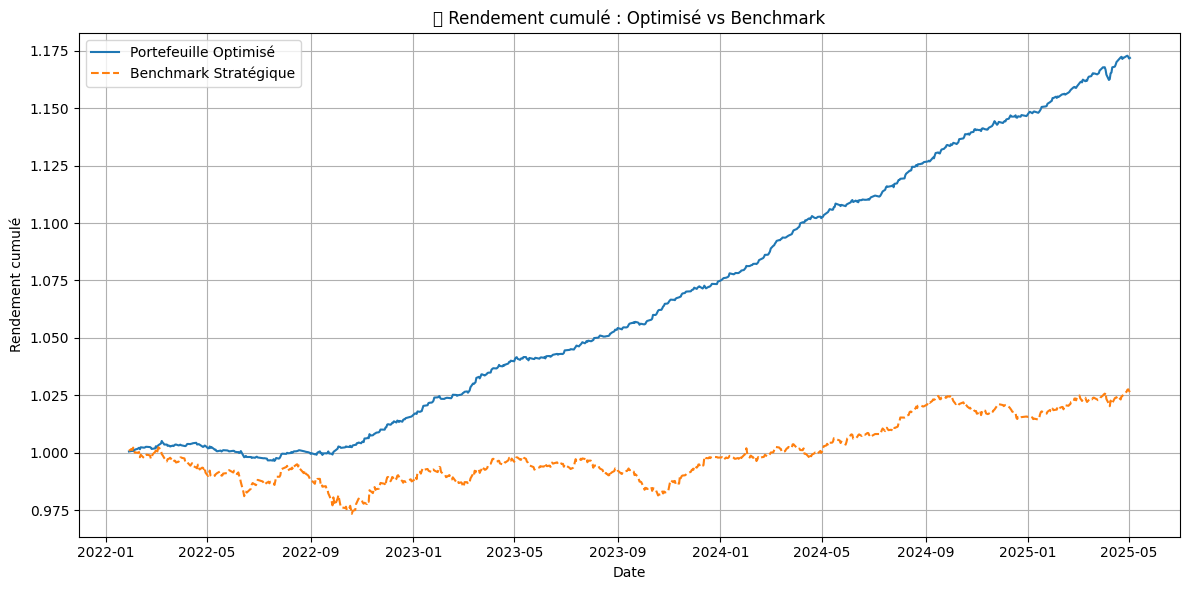


⚠️ Contribution au risque (chaque actif) :
      Ticker  Risk Contribution
14  CGL-C.TO       3.633542e-03
2       BITO       8.573812e-04
8     XEF.TO       7.054886e-04
1     XIU.TO       6.800027e-04
11  PSU-U.TO       4.586649e-04
13       SHV       4.443612e-04
0        GLD       2.802049e-04
10      BTAL       2.392770e-04
3    ZJPN.TO       1.976159e-04
6     XCB.TO       5.970418e-05
18    ZEM.TO       4.444789e-05
9        VEA       4.229560e-05
12       XLU       2.894150e-06
7        EWJ       2.120026e-06
15       XLP       3.577175e-07
4        LQD       5.698268e-19
5        IEF       5.605728e-19
17    ZRE.TO       5.432570e-19
16    ZUT.TO       4.199224e-19

📅 Rendements mensuels du portefeuille (composés) :
Date
2022-01-31    0.08%
2022-02-28    0.11%
2022-03-31    0.14%
2022-04-30   -0.03%
2022-05-31   -0.24%
2022-06-30   -0.26%
2022-07-31    0.16%
2022-08-31    0.04%
2022-09-30    0.09%
2022-10-31    0.32%
2022-11-30    0.69%
2022-12-31    0.46%
2023-01-31    0.84%

<ipython-input-4-2138413894>:101: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = (pnl + 1).resample('M').prod() - 1
<ipython-input-4-2138413894>:123: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


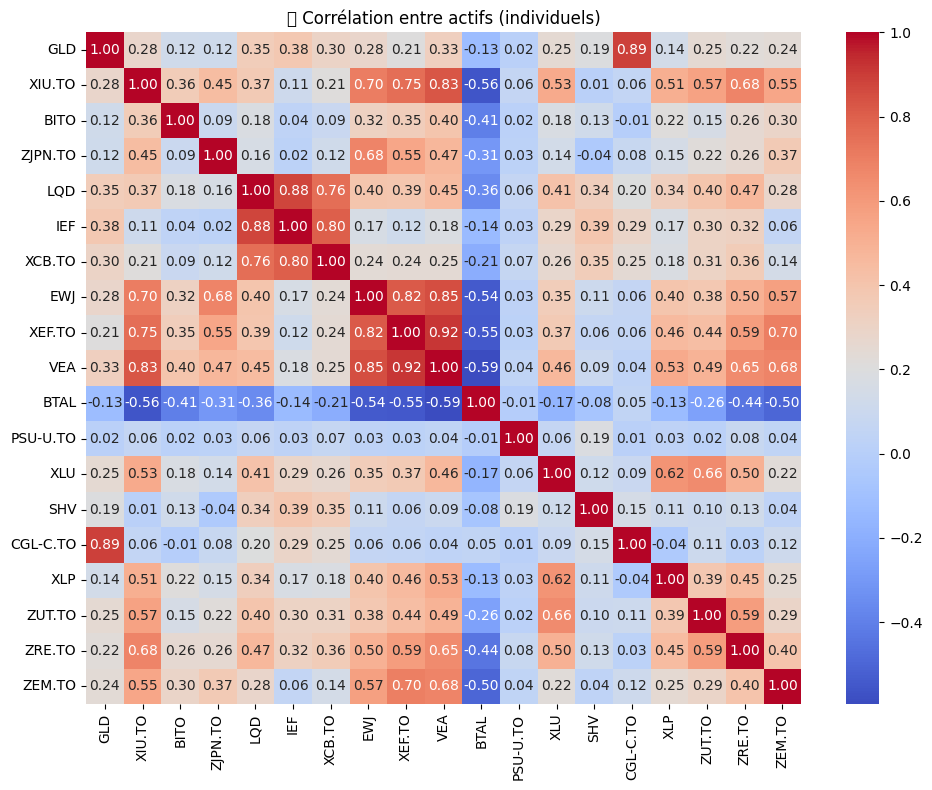

<ipython-input-4-2138413894>:129: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


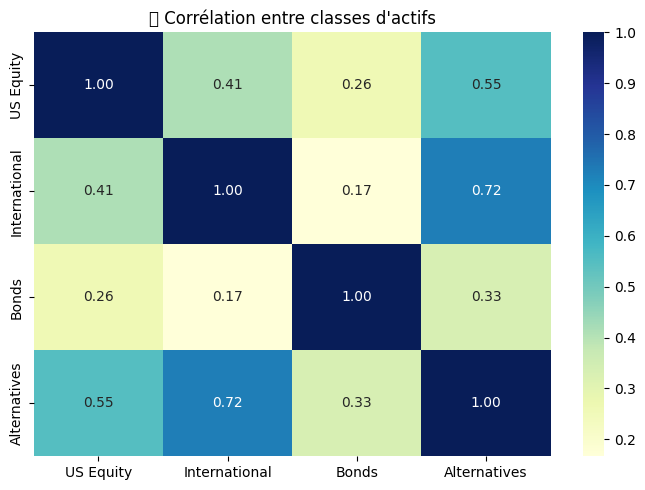

In [ ]:
results = analyze_portfolio_extended(df, benchmark_weights)


<ipython-input-10-4042725438>:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  class_returns_df = class_returns_df.groupby(level=0, axis=1).mean()
<ipython-input-7-4286089146>:53: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


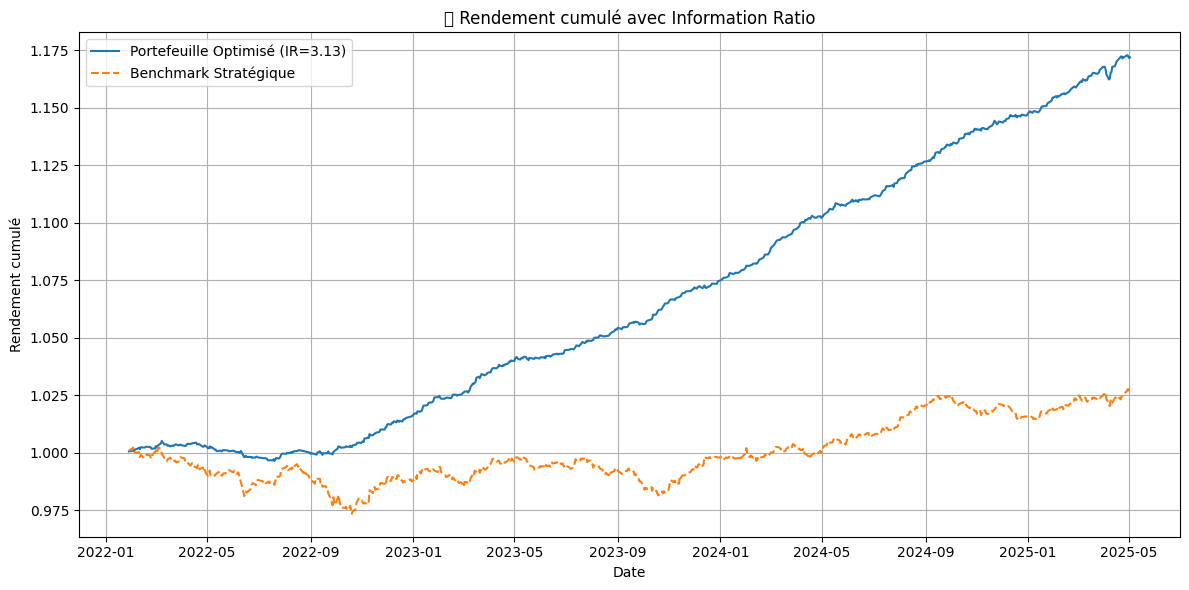

<ipython-input-7-4286089146>:64: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  safe_class_returns_df = safe_class_returns_df.groupby(level=0, axis=1).mean()
<ipython-input-7-4286089146>:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_class = (safe_class_returns_df + 1).resample("M").prod() - 1
<ipython-input-7-4286089146>:70: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


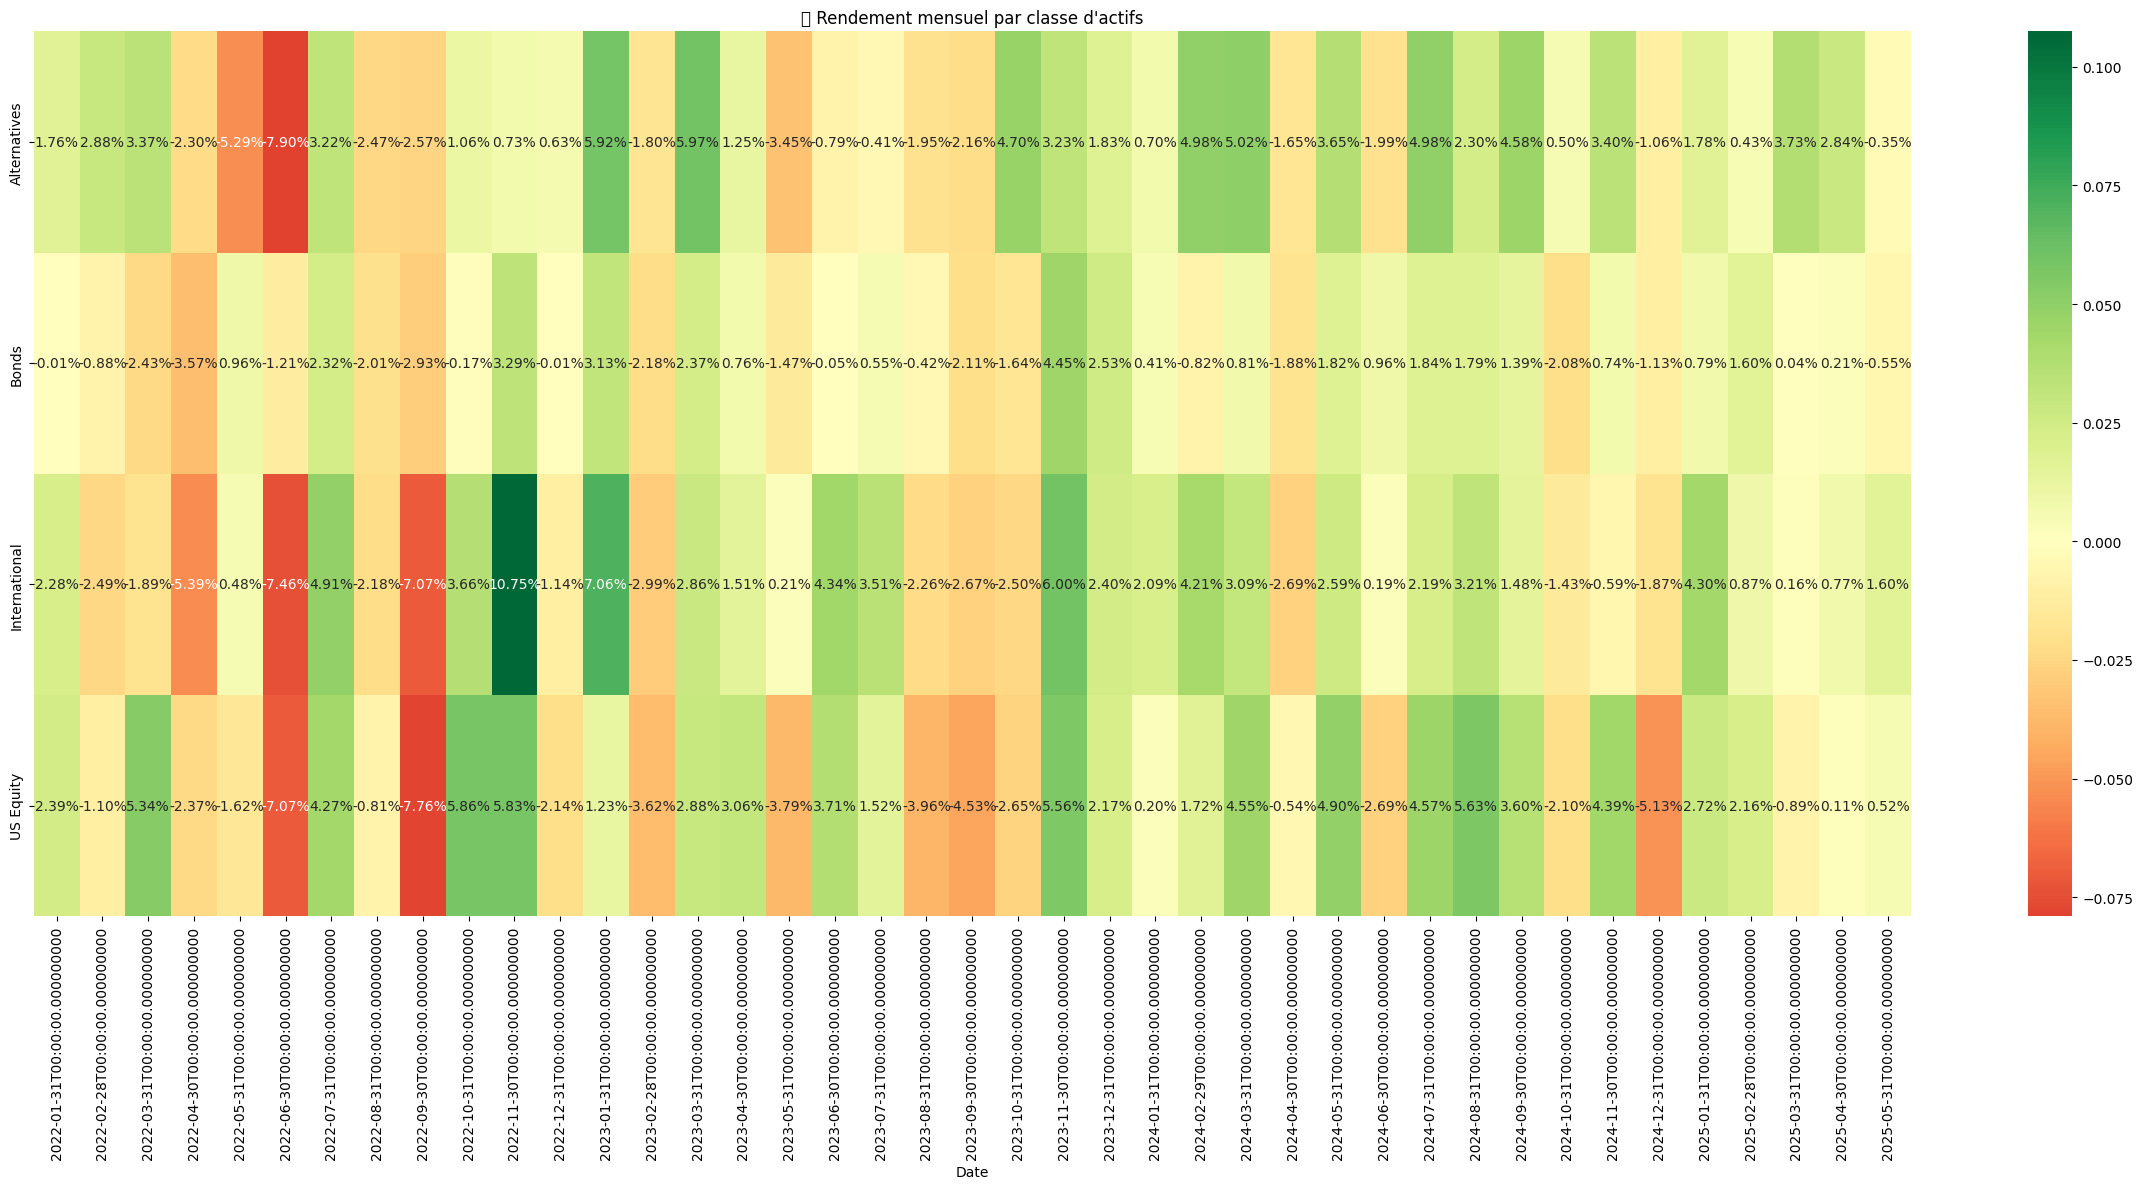

🎯 Sortino Ratio (corrigé) : 6.43

📊 Attribution de performance par classe :
               Allocation Effect  Selection Effect
Alternatives              0.0702            0.0000
Bonds                     0.0023           -0.0001
International             0.0007           -0.0002
US Equity                -0.0029           -0.0008


In [ ]:

returns = extract_returns_from_dataframe(df)[0]
weights = results["weights"]["Weight"].values
exp_returns = returns.mean() * 252

# Classe d’actifs par ticker
ticker_to_class = {
    # US Equity
    'SPY': 'US Equity', 'XLU': 'US Equity', 'XLP': 'US Equity', 'XIU.TO': 'US Equity',

    # International Equity
    'XIC.TO': 'International', 'IEFA': 'International', 'EWJ': 'International', 'VWO': 'International',
    'ZJPN.TO': 'International', 'XEF.TO': 'International', 'VEA': 'International', 'ZEM.TO': 'International',

    # Bonds
    'IEF': 'Bonds', 'SHV': 'Bonds', 'XCB': 'Bonds', 'XCB.TO': 'Bonds', 'LQD': 'Bonds',

    # Alternatives
    'IFRA': 'Alternatives', 'GOLD': 'Alternatives', 'VNQ': 'Alternatives', 'HEDGE': 'Alternatives',
    'BTC': 'Alternatives', 'GLD': 'Alternatives', 'BITO': 'Alternatives', 'BTAL': 'Alternatives',
    'CGL-C.TO': 'Alternatives', 'PSU-U.TO': 'Alternatives', 'ZUT.TO': 'Alternatives', 'ZRE.TO': 'Alternatives'
}


class_returns_df = returns.copy()
class_returns_df.columns = [ticker_to_class.get(t, "Unknown") for t in class_returns_df.columns]
class_returns_df = class_returns_df.groupby(level=0, axis=1).mean()

missing_tickers = [t for t in returns.columns if t not in ticker_to_class]
if missing_tickers:
    print("⚠️ Tickers non mappés :", missing_tickers)

# Rendement cumulé du portefeuille
cum_returns = (returns @ weights).add(1).cumprod()

# Rendement cumulé du benchmark
bench_weights_array = np.array([benchmark_weights.get(t, 0) for t in returns.columns])
cum_benchmark = (returns @ bench_weights_array).add(1).cumprod()

enhanced_results = post_analysis_enhancements(
    returns,
    weights,
    benchmark_weights,
    ticker_to_class,
    exp_returns,
    cum_returns,
    cum_benchmark,
    class_returns_df
)
